In [1]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple
import numpy as np
from gensim.models import doc2vec
LabelDocument = namedtuple('LabeledDocument', 'words tags label')

alldocs = []  # Will hold all docs in original order
with open('./janeausten/ja_COMBINED_treated.txt', encoding='utf-8') as alldata:
    for line_no, line in enumerate(alldata):
        tokens = gensim.utils.to_unicode(line).split()
    tokenArray = np.array_split(tokens,10000)
    for tokenList_no, tokens in enumerate(tokenArray):
        words = tokens[1:]
        tags = [tokenList_no] # 'tags = [tokens[0]]' would also work at extra memory cost
        label = ["janeausten"][line_no//12500] # [12.5K pos, 12.5K neg]*2 then unknown
        alldocs.append(LabelDocument(words, tags, label))

doc_list = alldocs[:]  # For reshuffling per pass

print('%d docs' % (len(doc_list)))
model_loaded = doc2vec.Doc2Vec.load('/tmp/marktwain_model.doc2vec')

10000 docs


In [2]:
alldocs = []
with open('./marktwain/combined.txt', encoding='utf-8') as alldata:
    for line_no, line in enumerate(alldata):
        tokens = gensim.utils.to_unicode(line).split()
    tokenArray = np.array_split(tokens,10000)
    for tokenList_no, tokens in enumerate(tokenArray):
        words = tokens[1:]
        tags = [10000+tokenList_no] # 'tags = [tokens[0]]' would also work at extra memory cost
        label = ["marktwain"][line_no//12500] # [12.5K pos, 12.5K neg]*2 then unknown
        alldocs.append(LabelDocument(words, tags, label))

mt_doc_list = alldocs[:]  # For reshuffling per pass

print('%d docs' % (len(mt_doc_list)))
doc_list += mt_doc_list

10000 docs


In [3]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

simple_models = [
    # PV-DM w/ concatenation - window=5 (both sides) approximates paper's 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW 
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DM w/ average
    Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
]

# Speed up setup by sharing results of the 1st model's vocabulary scan
simple_models[0].build_vocab(doc_list)  # PV-DM w/ concat requires one special NULL word so it serves as template
print(simple_models[0])
for model in simple_models[1:]:
    model.reset_from(simple_models[0])
    print(model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t8)
Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)
Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t8)


In [4]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[1], simple_models[2]])
models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[1], simple_models[0]])

In [5]:
model1 = Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
model1.build_vocab(doc_list)
len(doc_list)

20000

In [6]:
import pandas as pd
X = []
yzero = np.zeros(10000)
yone = np.ones(10000)
yzero = pd.DataFrame(yzero)
yone = pd.DataFrame(yone)
Y = pd.concat([yzero,yone])

In [7]:
%store model1

Stored 'model1' (Doc2Vec)


In [8]:
for dv in model1.docvecs:
    X.append(dv)
trainX = pd.DataFrame(X)
trainX.columns.astype(str)
Y.columns.astype(str)

Index(['0'], dtype='object')

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, Y, test_size=0.25)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15000, 100) (15000, 1)
(5000, 100) (5000, 1)


In [10]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
#xgb model with parameters
gbm = xgb.XGBClassifier(num_class=2, max_depth=3, n_estimators=300, learning_rate=0.05)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [11]:
gbm.fit(X_train, y_train)
predictions = gbm.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: 'int' object is not iterable

In [12]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
rbf1 = SVC(C=1.0, kernel='poly',degree=6)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
rbf1.fit(X_train,y_train)
rbfpredictions = rbf1.predict(X_test)
accuracy = accuracy_score(y_test, rbfpredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 49.76%


In [14]:
%store -r

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x108933ba8>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [15]:
newdoclist = []
for doc in doc_list:
    iv = combinedmodel.infer_vector(doc.words)
    newdoclist.append(iv)
len(newdoclist)


20000

In [36]:
%store model_loaded

Stored 'model_loaded' (Doc2Vec)


In [16]:
import pandas as pd
trainX2 = pd.DataFrame(newdoclist)

In [17]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train, y_test = train_test_split(trainX2, Y, test_size=0.25)
print (X_train2.shape, y_train.shape)
print (X_test2.shape, y_test.shape)

(15000, 100) (15000, 1)
(5000, 100) (5000, 1)


In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
clf = RandomForestClassifier(max_depth=2, random_state=0)
rbf2 = SVC(C=1.0, kernel='rbf')
rbf2.fit(X_train2,y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
rbfpredictions = rbf2.predict(X_test2)
accuracy = accuracy_score(y_test, rbfpredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.38%


In [23]:
gbm = xgb.XGBClassifier(num_class=2, max_depth=3, n_estimators=300, learning_rate=0.05)
gbm.fit(X_train2, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: 'int' object is not iterable

In [21]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=50, random_state=0)
rfc.fit(X_train2, y_train)
rfcpredictions = rfc.predict(X_test2)
accuracy = accuracy_score(y_test, rfcpredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy: 79.96%


In [22]:
#logistic regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression()
logreg.fit(X_train2, y_train)
logregpredictions = logreg.predict(X_test2)
accuracy = accuracy_score(y_test, logregpredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.64%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X_train2, y_train)
mlppredictions = mlp.predict(X_test2)
accuracy = accuracy_score(y_test, mlppredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 89.68%


In [29]:
# IMPORTANT: first argument is true values, second argument is predicted values
from sklearn import metrics

# this produces a 2x2 numpy array (matrix)
print(metrics.confusion_matrix(y_test, mlppredictions))

[[2330  188]
 [ 222 2260]]


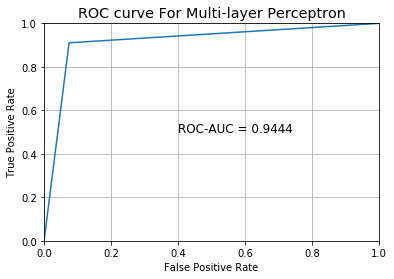

In [30]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, mlppredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve For Multi-layer Perceptron')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.text(0.4, 0.5, 'ROC-AUC = 0.9444')
plt.show()


In [31]:
print(metrics.roc_auc_score(y_test, mlppredictions))

0.917946786361


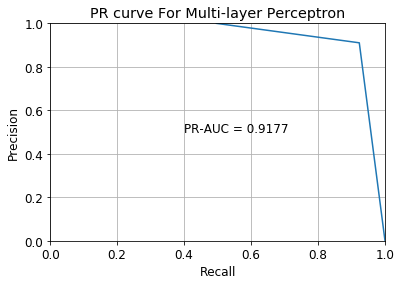

In [32]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mlppredictions)
plt.plot(precision, recall)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('PR curve For Multi-layer Perceptron')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.text(0.4, 0.5, 'PR-AUC = 0.9177')
plt.show()


In [33]:
print(metrics.average_precision_score(y_test, mlppredictions))

0.885027682714


In [34]:
%store mlp

Stored 'mlp' (MLPClassifier)


In [35]:
%store

Stored variables and their in-db values:
CYcountsArray                 -> [{'PRON': 0.09055118110236221, 'VERB': 0.141732283
CYtrainX                      ->              .       ADJ       ADP       ADV      
emmatrainX                    ->              .       ADJ       ADP       ADV      
filestring                    -> 'a connecticut yankee in king arthurs court a word
hfTrainX                      ->              .       ADJ       ADP       ADV      
jaArray                       -> [[['chapter', 'emma', 'woodhouse', 'handsome', 'cl
janeaustenDocVecs             -> <gensim.models.doc2vec.DocvecsArray object at 0x13
janeaustenTrainX              ->              .       ADJ       ADP       ADV      
janeaustenTrainY              ->         0
0     0.0
1     0.0
2     0.0
3     0.0

marktwainDocVecs              -> <gensim.models.doc2vec.DocvecsArray object at 0x13
mlp                           -> MLPClassifier(activation='relu', alpha=0.0001, bat
model1                        -> <g